Данные для семинара - https://drive.google.com/file/d/1GQm-IH3iGu1-HVjZ5npL5xeKovp0Aa60/view?usp=sharing

In [0]:
!pip install pandas scikit-learn gensim matplotlib

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import gensim
%matplotlib inline

In [3]:
from google.colab import drive 
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
quora = pd.read_csv('/gdrive/My Drive/data.zip (Unzipped Files)/quora.csv')

In [0]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [0]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

In [0]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 4:
        filtered_vocab.add(word)

In [8]:
len(filtered_vocab)

53528

In [0]:
word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [0]:
id2word = {i:word for word, i in word2id.items()}

In [0]:
X = []

for text in quora.question_text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [0]:
MAX_LEN = max(len(x) for x in X)

In [13]:
MAX_LEN

134

In [14]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
X.shape

(1306122, 134)

In [0]:
y = quora.target.values

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42)

## Конкатенация эмбеддингов

In [0]:
model = tf.keras.Sequential()

In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=10)(inputs)
conc_emb = tf.keras.layers.Flatten()(embeddings)

dense = tf.keras.layers.Dense(64, activation='relu')(conc_emb)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [191]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=25000,
         epochs=10)

Epoch 1/10
50/50 [==============================] - 24s 485ms/step - loss: 0.1668 - root_mean_squared_error: 0.4090 - val_loss: 0.0974 - val_root_mean_squared_error: 0.3121
Epoch 2/10
50/50 [==============================] - 24s 484ms/step - loss: 0.0739 - root_mean_squared_error: 0.2719 - val_loss: 0.0606 - val_root_mean_squared_error: 0.2463
Epoch 3/10
50/50 [==============================] - 24s 486ms/step - loss: 0.0594 - root_mean_squared_error: 0.2438 - val_loss: 0.0566 - val_root_mean_squared_error: 0.2383
Epoch 4/10
50/50 [==============================] - 24s 482ms/step - loss: 0.0576 - root_mean_squared_error: 0.2400 - val_loss: 0.0558 - val_root_mean_squared_error: 0.2365
Epoch 5/10
50/50 [==============================] - 24s 481ms/step - loss: 0.0571 - root_mean_squared_error: 0.2390 - val_loss: 0.0555 - val_root_mean_squared_error: 0.2358
Epoch 6/10
50/50 [==============================] - 24s 483ms/step - loss: 0.0568 - root_mean_squared_error: 0.2384 - val_loss: 0.0552 

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


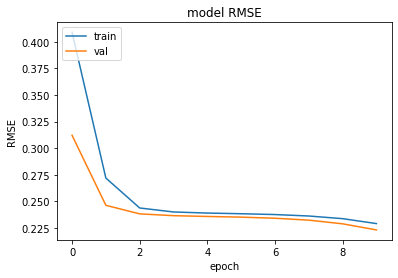

In [192]:
print(model.history.history.keys())
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Мы можем наблюдать, что при конкатенации векторов валидация практически перестает меняться, начиная со 2-й эпохи и далее

## Усреднение эмбеддингов

In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))


embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=10)(inputs)
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(mean)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [179]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=25000,
         epochs=10)

Epoch 1/10
50/50 [==============================] - 16s 327ms/step - loss: 0.2474 - root_mean_squared_error: 0.4974 - val_loss: 0.2444 - val_root_mean_squared_error: 0.4944
Epoch 2/10
50/50 [==============================] - 16s 322ms/step - loss: 0.2417 - root_mean_squared_error: 0.4916 - val_loss: 0.2386 - val_root_mean_squared_error: 0.4884
Epoch 3/10
50/50 [==============================] - 16s 321ms/step - loss: 0.2352 - root_mean_squared_error: 0.4850 - val_loss: 0.2313 - val_root_mean_squared_error: 0.4810
Epoch 4/10
50/50 [==============================] - 16s 323ms/step - loss: 0.2275 - root_mean_squared_error: 0.4770 - val_loss: 0.2231 - val_root_mean_squared_error: 0.4723
Epoch 5/10
50/50 [==============================] - 16s 325ms/step - loss: 0.2187 - root_mean_squared_error: 0.4677 - val_loss: 0.2135 - val_root_mean_squared_error: 0.4621
Epoch 6/10
50/50 [==============================] - 17s 331ms/step - loss: 0.2082 - root_mean_squared_error: 0.4564 - val_loss: 0.2022 

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


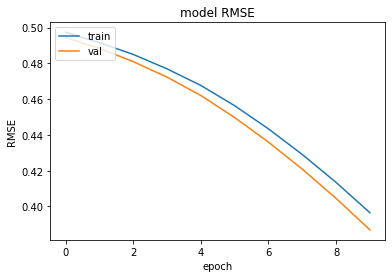

In [180]:
print(model.history.history.keys())
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

При усреднении эмбеддингов мы наблюдаем, что с каждой эпохой качество обеих выборок постепенно растет на валидационной и тренировочной выборках: среднеквадратическая ошибка уменьшается от 0.5 к 0.4. (при батче 5000 результат был получше - от 0.45 к 0.2)

## Сложение эмбеддингов

In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))


embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=10)(inputs)
emb_sum = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x,  axis=1))(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(emb_sum)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [182]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=25000,
         epochs=10)

Epoch 1/10
50/50 [==============================] - 16s 320ms/step - loss: 0.0571 - root_mean_squared_error: 0.2390 - val_loss: 0.0553 - val_root_mean_squared_error: 0.2355
Epoch 2/10
50/50 [==============================] - 16s 316ms/step - loss: 0.0565 - root_mean_squared_error: 0.2378 - val_loss: 0.0547 - val_root_mean_squared_error: 0.2341
Epoch 3/10
50/50 [==============================] - 16s 319ms/step - loss: 0.0557 - root_mean_squared_error: 0.2359 - val_loss: 0.0535 - val_root_mean_squared_error: 0.2315
Epoch 4/10
50/50 [==============================] - 16s 320ms/step - loss: 0.0541 - root_mean_squared_error: 0.2326 - val_loss: 0.0516 - val_root_mean_squared_error: 0.2273
Epoch 5/10
50/50 [==============================] - 16s 318ms/step - loss: 0.0518 - root_mean_squared_error: 0.2277 - val_loss: 0.0491 - val_root_mean_squared_error: 0.2218
Epoch 6/10
50/50 [==============================] - 16s 319ms/step - loss: 0.0492 - root_mean_squared_error: 0.2219 - val_loss: 0.0466 

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


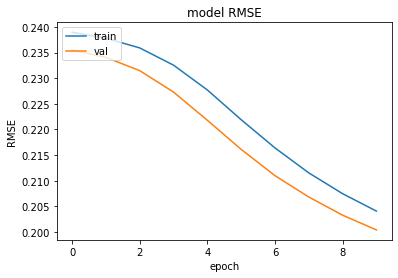

In [183]:
print(model.history.history.keys())
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

При сложении эмбеддингов мы получаем наименьший разброс. При этом среднеквадратическая ошибка достигает уровня около 0.2-0.21 (при батче 5000 результат был похожим)

## Использование 2 предобученных моделей

In [0]:
w2v = gensim.models.Word2Vec([preprocess(text) for text in quora.question_text], size=100)

In [0]:
ft = gensim.models.FastText([preprocess(text) for text in quora.question_text], size=100) 

In [0]:
w2v_weights = np.zeros((len(w2v.wv.vocab)+2, 100))
for i, vec in enumerate(w2v.wv.vectors): 
  w2v_weights[i] = w2v.wv[id2word[i+2]]  
  # id2word[0] и id2word[1] - это PAD и Unk, которые здесь считаются как нулевые векторы
  # вообще для unk надо бы наверное придумать какой-то вектор, а не просто игнорировать его...

In [0]:
ft_weights = np.zeros((len(ft.wv.vocab)+2, 100))
for i, vec in enumerate(ft.wv.vectors):
  ft_weights[i+2] = ft.wv[id2word[i+2]]

## Усреднение предобученных эмбеддингов

In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embedding1 = tf.keras.layers.Embedding(input_dim=len(w2v_weights), output_dim=100, weights=[w2v_weights])(inputs)
embedding2 = tf.keras.layers.Embedding(input_dim=len(ft_weights), output_dim=100, weights=[ft_weights])(inputs)
embeddings = tf.keras.layers.Average()([embedding1, embedding2])
emb_sum = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x,  axis=1))(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(emb_sum)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [208]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=10000, 
          epochs=4)

Epoch 1/4
125/125 [==============================] - 120s 963ms/step - loss: 0.1788 - root_mean_squared_error: 0.4239 - val_loss: 0.0600 - val_root_mean_squared_error: 0.2457
Epoch 2/4
125/125 [==============================] - 121s 965ms/step - loss: 0.0620 - root_mean_squared_error: 0.2489 - val_loss: 0.0600 - val_root_mean_squared_error: 0.2457
Epoch 3/4
125/125 [==============================] - 120s 959ms/step - loss: 0.0620 - root_mean_squared_error: 0.2489 - val_loss: 0.0600 - val_root_mean_squared_error: 0.2457
Epoch 4/4
125/125 [==============================] - 118s 944ms/step - loss: 0.0621 - root_mean_squared_error: 0.2489 - val_loss: 0.0600 - val_root_mean_squared_error: 0.2457


dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


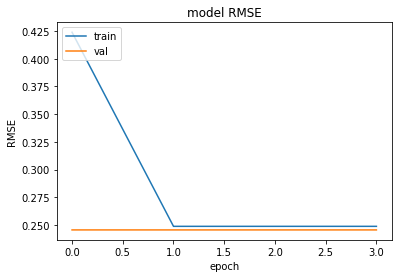

In [209]:
print(model.history.history.keys())
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

После 1-й эпохи ничего не меняется. Результат похуже, чем в предыдущем задании

## Конкатенация предобученных эмбеддингов

In [0]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embedding1 = tf.keras.layers.Embedding(input_dim=len(w2v_weights), output_dim=100, weights=[w2v_weights])(inputs)
embedding2 = tf.keras.layers.Embedding(input_dim=len(ft_weights), output_dim=100, weights=[ft_weights])(inputs)
embeddings = tf.keras.layers.Concatenate()([embedding1, embedding2])
emb_sum = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x,  axis=1))(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(emb_sum)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [211]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=10000, 
          epochs=4)

Epoch 1/4
125/125 [==============================] - 185s 1s/step - loss: 0.0621 - root_mean_squared_error: 0.2489 - val_loss: 0.0600 - val_root_mean_squared_error: 0.2457
Epoch 2/4
125/125 [==============================] - 187s 1s/step - loss: 0.0619 - root_mean_squared_error: 0.2489 - val_loss: 0.0600 - val_root_mean_squared_error: 0.2457
Epoch 3/4
125/125 [==============================] - 186s 1s/step - loss: 0.0620 - root_mean_squared_error: 0.2489 - val_loss: 0.0600 - val_root_mean_squared_error: 0.2457
Epoch 4/4
125/125 [==============================] - 188s 2s/step - loss: 0.0619 - root_mean_squared_error: 0.2489 - val_loss: 0.0600 - val_root_mean_squared_error: 0.2457


dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


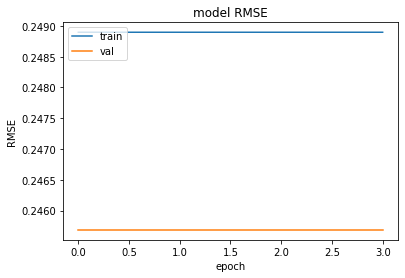

In [212]:
print(model.history.history.keys())
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Количество эпох ни на что не повлияло